### 01.- IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [34]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import os
import cv2
import tensorflow as tf
import numpy as np

In [36]:
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [37]:
# Especificar el directorio del conjunto de entrenamiento
XRay_Directory = "Dataset"

In [38]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [39]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [40]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "training")

Found 428 images belonging to 4 classes.


In [41]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "validation")

Found 104 images belonging to 4 classes.


In [42]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [43]:
train_images.shape

(40, 256, 256, 3)

In [44]:
train_labels.shape

(40, 4)

In [45]:
train_labels

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]],

In [46]:
# Traducción de cada Etiqueta
label_names = {0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia Virica', 3: 'Pneumonia Bacteriana'}

### 02.- VISUALIZACIÓN DEL DATASET

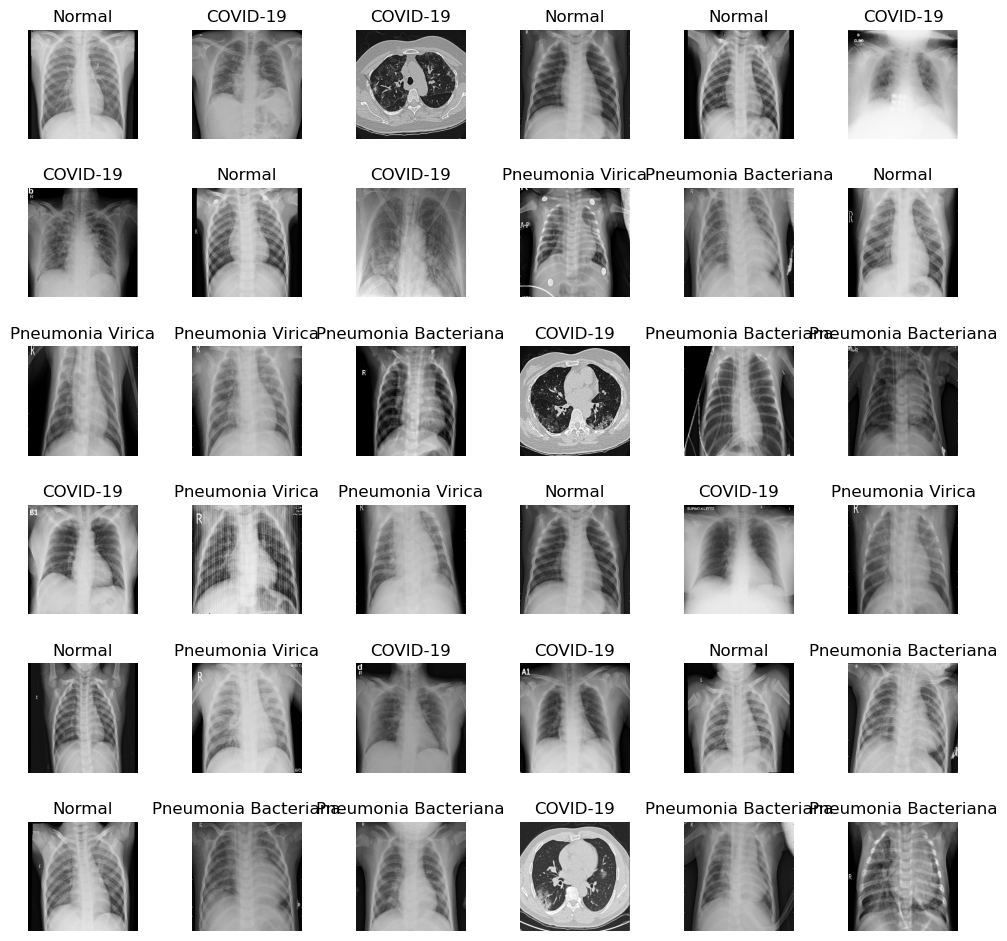

In [47]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

### 03.- IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS

In [48]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [49]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [50]:
# Congelar el modelo hasta las últimas etapas - 4 y llevar a cabo un re entrenamiento -5
for layer in basemodel.layers[:-10]:
    layer.trainable = False

### 04.- CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING

In [51]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [52]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.legacy.RMSprop(lr = 1e-4, decay = 1e-6), metrics = ["accuracy"])

In [53]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [54]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 428 images belonging to 4 classes.


Found 104 images belonging to 4 classes.


In [55]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25,
                              validation_data = val_generator, validation_steps = val_generator.n // 4,
                              callbacks = [checkpointer, earlystopping])

C:\Users\jose.lozas\AppData\Local\Temp\ipykernel_20288\3933769170.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25,


Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 1.4375 - accuracy: 0.3294
Epoch 1: val_loss improved from inf to 1.43236, saving model to weights.hdf5
107/107 [==============================] - 60s 515ms/step - loss: 1.4375 - accuracy: 0.3294 - val_loss: 1.4324 - val_accuracy: 0.2500
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 1.0890 - accuracy: 0.5374
Epoch 2: val_loss improved from 1.43236 to 1.29088, saving model to weights.hdf5
107/107 [==============================] - 45s 419ms/step - loss: 1.0890 - accuracy: 0.5374 - val_loss: 1.2909 - val_accuracy: 0.5288
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.9349 - accuracy: 0.6285
Epoch 3: val_loss improved from 1.29088 to 0.96401, saving model to weights.hdf5
107/107 [==============================] - 47s 438ms/step - loss: 0.9349 - accuracy: 0.6285 - val_loss: 0.9640 - val_accuracy: 0.5481
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0

### 05.- EVALUAR EL MODELO DE DEEP LEARNING ENTRENADO

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

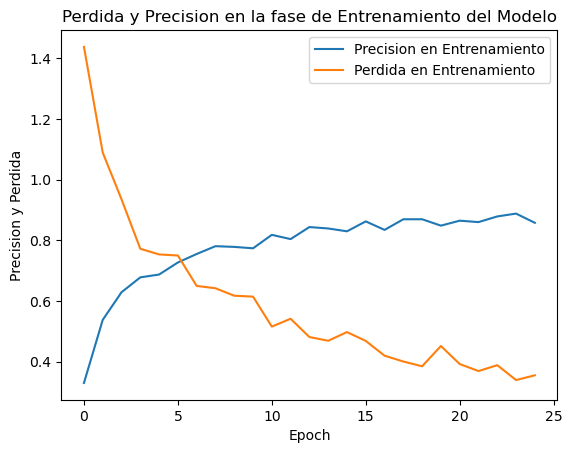

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

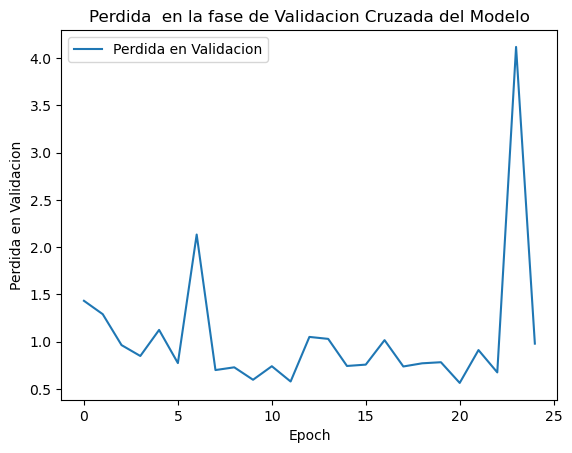

In [58]:
plt.plot(history.history['val_loss'])

plt.title("Perdida  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Perdida en Validacion")
plt.legend(["Perdida en Validacion"])

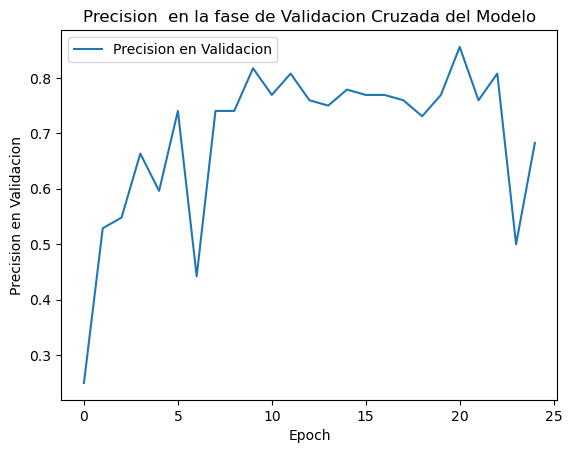

In [59]:
plt.plot(history.history['val_accuracy'])

plt.title("Precision  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision en Validacion")
plt.legend(["Precision en Validacion"])

In [68]:
test_directory = "Test"

In [69]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode="categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print("Precision en la fase de Test : {}".format(evaluate[1]))

Found 40 images belonging to 4 classes.


C:\Users\jose.lozas\AppData\Local\Temp\ipykernel_20288\2860625569.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)


10/10 [==============================] - 3s 3ms/step - loss: 1.4161 - accuracy: 0.5500
Precision en la fase de Test : 0.550000011920929


In [70]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 101ms/step


In [71]:
len(original)

40

In [72]:
score = accuracy_score(original, prediction)
print("Eficacia de la prediccion {}".format(score))

Eficacia de la prediccion 0.525


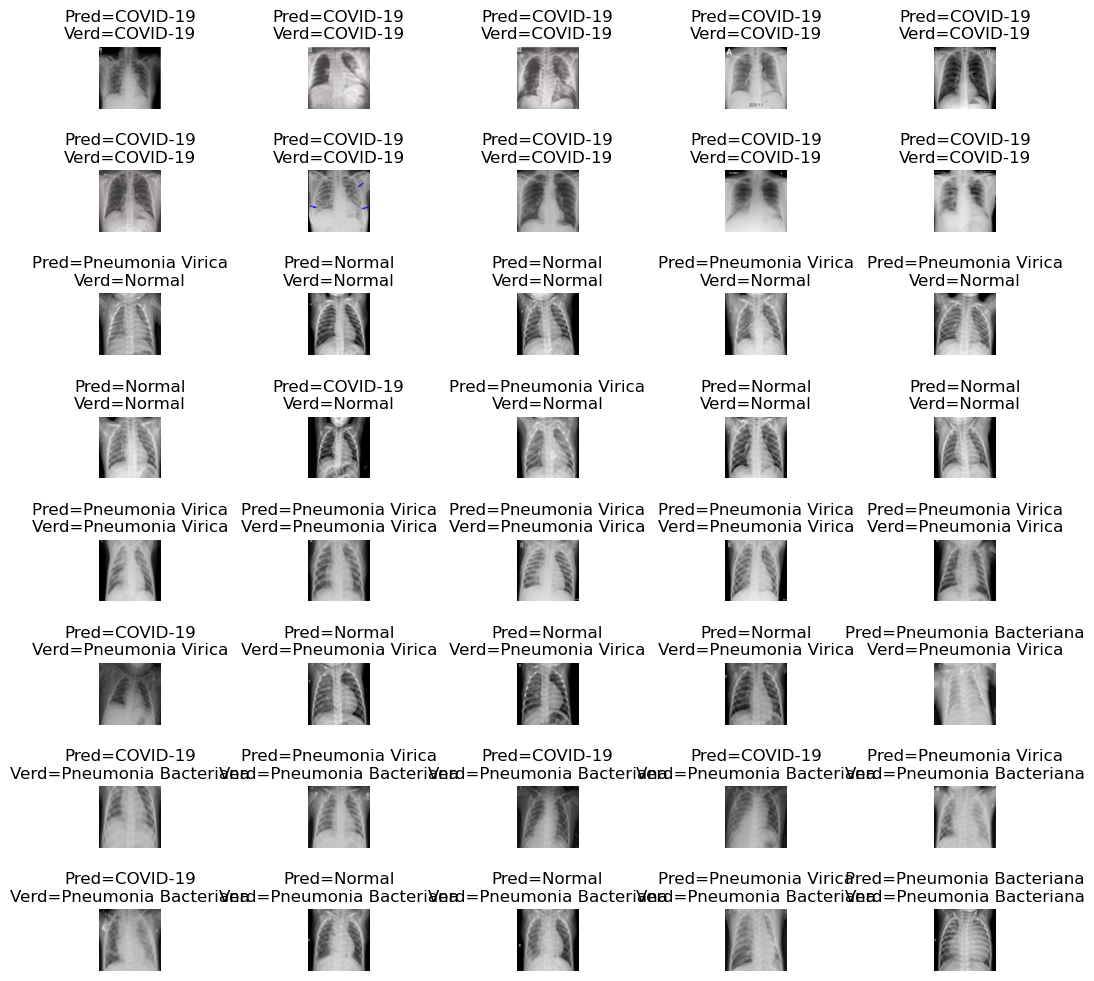

In [73]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [74]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.50      0.50      0.50        10
           2       0.42      0.50      0.45        10
           3       0.50      0.10      0.17        10

    accuracy                           0.53        40
   macro avg       0.51      0.53      0.47        40
weighted avg       0.51      0.53      0.47        40



Text(0.5, 1.0, 'Matriz de Confusion')

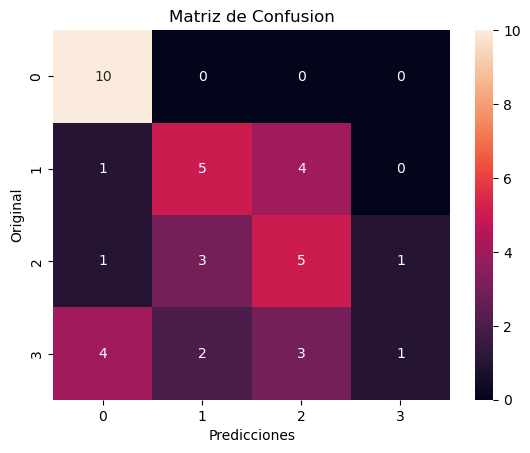

In [75]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")